# **Team Name : 404 Team Not Found**

####    Members : Armand Hubler, Anthony-Lee Sanchez, Aswin Subramanian Maheswaran, Daniel Rosel and Marco Celati

## Challenge 1

+ Forecast hourly energy offers for each of the power plant.

+ Your forecasts will cover the period from June 1, 2024, at 23:00 to June 29, 2024, at 23:00.

+ Evaluated using Mean Absolute Percentage Error (MAPE) and Mean Absolute Error (MAE), calculated for each plant’s time series and then averaged across all plants.

####    Output Format:

Produce a CSV file with three columns:

+ Codigo (plant identifier)

+ fechaHora (timestamp)

+ Energia (forecasted energy offer)

In [26]:
%pip install lightgbm xgboost scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [27]:
# Importing the necessary libraries

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [28]:
# Load the data

## This file contains historical data from around March to May 2024.

df_omie_labelled = pd.read_csv('../data/df_omie_labelled.csv')

# ---------------------

## Contains information on the technology type (Wind or Solar) for each plant, 
## which may be useful for grouping. 

df_filtered_cat = pd.read_csv('../data/filtered_categories.csv')

# ---------------------
## Additional information about generation units that you can use if needed.

df_unit_list = pd.read_csv('../data/unit_list.csv')

In [29]:
# 1. Converting the fechaHora to datetime

df_omie_labelled["fechaHora"] = pd.to_datetime(df_omie_labelled["fechaHora"])

date_range = df_omie_labelled["fechaHora"].min(), df_omie_labelled["fechaHora"].max()
print()
print("Date Range:", date_range)

df_omie_labelled["date"] = df_omie_labelled["fechaHora"].dt.date
df_omie_labelled["hour"] = df_omie_labelled["fechaHora"].dt.hour
df_omie_labelled["week"] = df_omie_labelled["fechaHora"].dt.isocalendar().week


Date Range: (Timestamp('2024-02-29 00:00:00'), Timestamp('2024-06-01 22:00:00'))


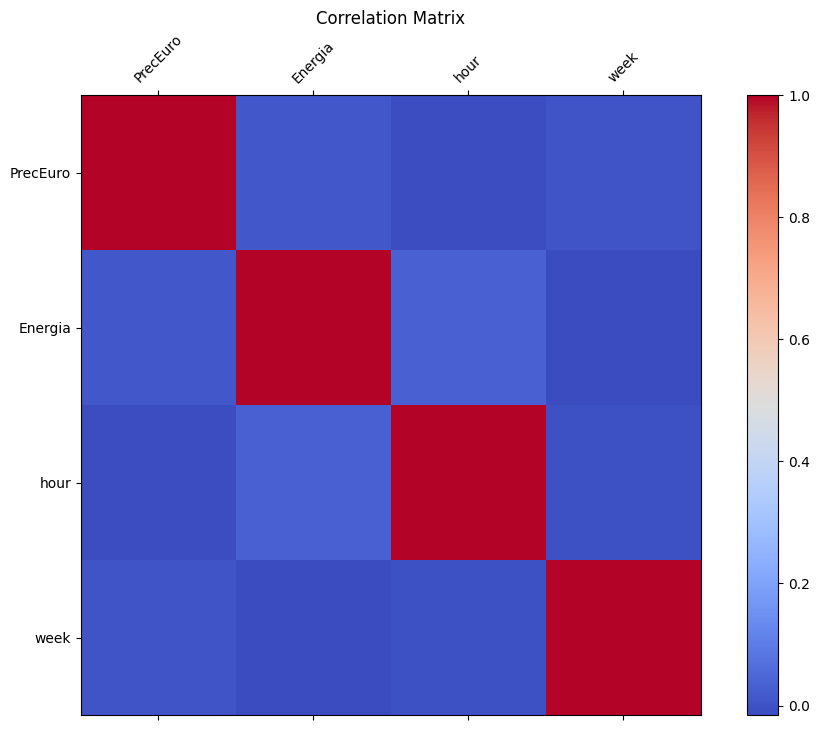

In [30]:
# 2. Correlation matrix 

numerical_cols = df_omie_labelled.select_dtypes(include=[np.number]).columns

corr_matrix = df_omie_labelled[numerical_cols].corr()

plt.figure(figsize=(12, 8))
plt.matshow(corr_matrix, cmap="coolwarm", fignum=1)
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title("Correlation Matrix")
plt.show()


## Feature Engineering

In [31]:
def prepare_merged_dataframe(df_omie_labelled, df_filtered_cat, df_unit_list):
    """
    Perform feature engineering on three DataFrames and merge them.
    
    Parameters:
    
      - df_omie_labelled: DataFrame containing energy offers with a 'fechaHora' column.
      - df_filtered_cat: DataFrame containing plant category info (merged later on 'Codigo').
      - df_unit_list: DataFrame containing generation unit details (includes 'Agente' and 'Porcentaje_Propiedad').
    
    The function performs the following steps:
    
      1. For df_omie_labelled:
         - Convert 'fechaHora' to datetime and create a 'date' column.
         - Extract hour, day-of-week, month, day-of-month, and create an 'is_weekend' flag.
         - Add cyclical features for hour and day-of-week.
         - Create an interaction feature and cumulative energy feature.
      2.  df_filtered_cat
      3.  df_unit_list
      4. Merge the DataFrames on 'Codigo' and sort by 'Codigo' and 'fechaHora'.
      5. On the merged DataFrame:
         - Create a time variable 't' in hours relative to the overall start.
         - Add Fourier series terms for daily (period=24) and weekly (period=168) seasonality.
         - Create lag features (1-hour and 24-hour lags) for 'Energia' and a rolling 24-hour mean.
    
    Returns:
      - df_merged: The merged and feature-engineered DataFrame.
    """
    
    #-----------------------1. Process df_omie_labelled-----------------------
    
    # Convert 'fechaHora' to datetime and create additional time features.
    
    df_omie_labelled['fechaHora'] = pd.to_datetime(df_omie_labelled['fechaHora'])
    df_omie_labelled['date'] = df_omie_labelled['fechaHora'].dt.date
    df_omie_labelled['hour'] = df_omie_labelled['fechaHora'].dt.hour
    df_omie_labelled['day_of_week'] = df_omie_labelled['fechaHora'].dt.dayofweek  # Monday=0, Sunday=6
    df_omie_labelled['month'] = df_omie_labelled['fechaHora'].dt.month
    df_omie_labelled['day_of_month'] = df_omie_labelled['fechaHora'].dt.day
    df_omie_labelled['is_weekend'] = df_omie_labelled['day_of_week'].isin([5, 6]).astype(int)
    
    # Cyclical encodings for hour and day-of-week
    
    df_omie_labelled['hour_sin'] = np.sin(2 * np.pi * df_omie_labelled['hour'] / 24)
    df_omie_labelled['hour_cos'] = np.cos(2 * np.pi * df_omie_labelled['hour'] / 24)
    df_omie_labelled['dow_sin'] = np.sin(2 * np.pi * df_omie_labelled['day_of_week'] / 7)
    df_omie_labelled['dow_cos'] = np.cos(2 * np.pi * df_omie_labelled['day_of_week'] / 7)
    
    # Interaction: multiply Energia with hour_sin
    
    df_omie_labelled['energia_hour_sin'] = df_omie_labelled['Energia'] * df_omie_labelled['hour_sin']
    
    # Cumulative energy per plant per day
    
    df_omie_labelled['cum_energy'] = df_omie_labelled.groupby(['Codigo', 'date'])['Energia'].cumsum()
    
    # Print missing values info for df_omie_labelled
    
    missing_values = df_omie_labelled.isnull().sum()
    print("Missing Values in df_omie_labelled:\n", missing_values)
    missing_percentage = (df_omie_labelled.isnull().sum() / len(df_omie_labelled)) * 100
    print("\nPercentage of Missing Values in df_omie_labelled:\n", missing_percentage)
    
    #-----------------------2. Process df_filtered_cat-----------------------
    
    print("\ndf_filtered_cat Columns:\n", df_filtered_cat.columns)
    
    #----------------------- 3. Process df_unit_list -----------------------
    
    print("\nSample 'Codigo' from df_unit_list:\n", df_unit_list['Codigo'].sample(10))
    # Compute agent frequency and merge average ownership percentage per agent
    agent_counts = df_unit_list['Agente'].value_counts().to_dict()
    df_unit_list['agent_frequency'] = df_unit_list['Agente'].map(agent_counts)
    agent_avg_prop = (df_unit_list.groupby('Agente')['Porcentaje_Propiedad']
                      .mean()
                      .reset_index()
                      .rename(columns={'Porcentaje_Propiedad': 'avg_propiedad_by_agent'}))
    df_unit_list = df_unit_list.merge(agent_avg_prop, on='Agente', how='left')
    
    #----------------------- 4. Merge the datasets-----------------------
    
    df_merged = pd.merge(df_omie_labelled, df_filtered_cat, on='Codigo', how='left')
    df_merged = pd.merge(df_merged, df_unit_list, on='Codigo', how='left')
    
    # Sort the merged DataFrame by plant and timestamp
    
    df_merged = df_merged.sort_values(['Codigo', 'fechaHora'])
    
    print("\nMerged DataFrame shape:", df_merged.shape)
    print("Merged DataFrame columns:", df_merged.columns)
    print("Merged DataFrame datatypes:\n", df_merged.dtypes)
    
    # ----------------------- 5. Additional Feature Engineering on df_merged -----------------------
    
    df_merged['fechaHora'] = pd.to_datetime(df_merged['fechaHora'])
    
    # Create a new time variable 't' (in hours) relative to the overall start time
    
    df_merged['t'] = (df_merged['fechaHora'] - df_merged['fechaHora'].min()).dt.total_seconds() / 3600
    
    # Function to add Fourier series terms
    
    def add_fourier_terms(data, period, K, time_col='t'):
        for k in range(1, K + 1):
            data[f'sin_{period}_{k}'] = np.sin(2 * np.pi * k * data[time_col] / period)
            data[f'cos_{period}_{k}'] = np.cos(2 * np.pi * k * data[time_col] / period)
        return data
    
    # Add Fourier terms for daily (period=24) and weekly (period=168) seasonality
    
    df_merged = add_fourier_terms(df_merged, period=24, K=3, time_col='t')
    df_merged = add_fourier_terms(df_merged, period=168, K=3, time_col='t')
    
    # Create lag features for Energia: 1-hour and 24-hour lags
    
    df_merged['lag1_Energia'] = df_merged.groupby('Codigo')['Energia'].shift(1)
    df_merged['lag24_Energia'] = df_merged.groupby('Codigo')['Energia'].shift(24)
    
    # Create a rolling 24-hour mean for Energia
    
    df_merged['roll24_mean_Energia'] = df_merged.groupby('Codigo')['Energia'] \
        .transform(lambda x: x.rolling(window=24, min_periods=1).mean())
    
    return df_merged


In [32]:
merged_df = prepare_merged_dataframe(df_omie_labelled, df_filtered_cat, df_unit_list)
print(merged_df.head())

Missing Values in df_omie_labelled:
 Codigo                 0
Descripcion         9016
fechaHora           9016
PrecEuro            9016
Energia             9016
date                9016
hour                9016
week                9016
day_of_week         9016
month               9016
day_of_month        9016
is_weekend             0
hour_sin            9016
hour_cos            9016
dow_sin             9016
dow_cos             9016
energia_hour_sin    9016
cum_energy          9016
dtype: int64

Percentage of Missing Values in df_omie_labelled:
 Codigo              0.000000
Descripcion         1.265823
fechaHora           1.265823
PrecEuro            1.265823
Energia             1.265823
date                1.265823
hour                1.265823
week                1.265823
day_of_week         1.265823
month               1.265823
day_of_month        1.265823
is_weekend          0.000000
hour_sin            1.265823
hour_cos            1.265823
dow_sin             1.265823
dow_cos      

In [33]:
merged_df.shape

(712264, 43)

## Modelling


In [34]:
# forecast period boundaries

forecast_start = pd.Timestamp('2024-06-01 23:00:00')
forecast_end   = pd.Timestamp('2024-06-29 23:00:00')


# Training data: all data before the forecast_start

train_df = merged_df[merged_df['fechaHora'] < forecast_start].copy()


In [35]:
# Define features: categorical, numerical, and metadata features

categorical_features = ['Codigo'] + [col for col in ['Categoria', 'Tipo_Unidad', 'Zona/Frontera', 'Tecnología', 'Agente'] if col in train_df.columns]

numerical_features = [col for col in [
    'PrecEuro', 'cum_energy', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'energia_hour_sin',
    'sin_24_1', 'cos_24_1', 'sin_24_2', 'cos_24_2', 'sin_24_3', 'cos_24_3', 'sin_168_1',
    'cos_168_1', 'sin_168_2', 'cos_168_2', 'sin_168_3', 'cos_168_3',
    'lag1_Energia', 'lag24_Energia', 'roll24_mean_Energia',
    'hour', 'day_of_week', 'month', 'day_of_month', 'week', 'is_weekend'
] if col in train_df.columns]  # Note: 'Energia' is removed

metadata_features = [col for col in ['agent_frequency', 'avg_propiedad_by_agent'] if col in train_df.columns]

# Final feature list and target definition

feature_cols = categorical_features + numerical_features + metadata_features
target_col = 'Energia'

# Convert categorical features to 'category' dtype

for col in categorical_features:
    if col in train_df.columns:
        train_df[col] = train_df[col].astype('category')

if not np.issubdtype(train_df['fechaHora'].dtype, np.datetime64):
    train_df['fechaHora'] = pd.to_datetime(train_df['fechaHora'])

train_df = train_df.dropna(subset=[target_col])


In [36]:
# --------------- Create Zero Indicator Feature ------------------

# A zero indicator feature is added to help the model differentiate between zero and non-zero regimes.

train_df['zero_indicator'] = (train_df[target_col] == 0).astype(int)
if 'zero_indicator' not in feature_cols:
    feature_cols.append('zero_indicator')

# Split data into features and target

X = train_df[feature_cols]
y = train_df[target_col]

print(f"Total training samples: {X.shape[0]}")


Total training samples: 703248


In [37]:
# TimeSeriesSplit with 5 splits, a test set of 24*30 (720 hours, i.e. 30 days), and a gap of 24 hours
num_codigos = train_df['Codigo'].nunique()
tss = TimeSeriesSplit(n_splits=3, test_size=24 * 28 * num_codigos, gap=24)

epsilon = 0.001

def adjusted_mape(y_true, y_pred, epsilon=epsilon):
    """Adjusted MAPE: adds epsilon to denominator to avoid division by zero."""
    return np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + epsilon))

# Best hyperparameters from Bayesian optimization (plus our regularization)

params_lgb = {
    'objective': 'tweedie',
    'tweedie_variance_power': 1.5,
    'metric': 'mae',
    'learning_rate': 0.04139126441377782,
    'num_leaves': 59,
    'max_depth': 7,
    'min_data_in_leaf': 26,
    'feature_fraction': 0.9999701887398744,
    'bagging_fraction': 0.6553188710984839,
    'bagging_freq': 6,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbose': -1,
    'seed': 42
}

mae_scores = []
mape_scores = []
fold = 1


####    Hyperparameter Tuning + LightGBM

+ Bayesian Optimization with Optuna to tune LightGBM’s hyperparameters using time-series cross-validation. 

+ Set up a search space for several key LightGBM hyperparameters (learning rate, num_leaves, max_depth, etc.).

+ We create an Optuna study in minimization mode and run 50 trials to find the best set of hyperparameters. After the study, we print out the best metrics and the corresponding hyperparameters.


In [38]:
for train_index, val_index in tss.split(X):
    
    X_tr = X.iloc[train_index]
    y_tr = y.iloc[train_index]
    X_val_fold = X.iloc[val_index]
    y_val_fold = y.iloc[val_index]
    
    # When constructing the LightGBM Dataset, we include both original categorical features and the zero_indicator
    
    lgb_train = lgb.Dataset(X_tr, label=y_tr, categorical_feature=categorical_features + ['zero_indicator'])
    lgb_val = lgb.Dataset(X_val_fold, label=y_val_fold, categorical_feature=categorical_features + ['zero_indicator'])
    
    model = lgb.train(
        params_lgb,
        lgb_train,
        num_boost_round=1000,
        valid_sets=[lgb_train, lgb_val],
        callbacks=[lgb.early_stopping(stopping_rounds=50)]
    )
    
    y_pred_fold = model.predict(X_val_fold, num_iteration=model.best_iteration)
    fold_mae = mean_absolute_error(y_val_fold, y_pred_fold)
    fold_mape = adjusted_mape(y_val_fold, y_pred_fold)
    print(f"Fold {fold}: MAE = {fold_mae:.4f}, MAPE = {fold_mape:.4f}")
    mae_scores.append(fold_mae)
    mape_scores.append(fold_mape)
    fold += 1


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[920]	training's l1: 0.341878	valid_1's l1: 14.5895
Fold 1: MAE = 14.5895, MAPE = 0.1073
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[997]	training's l1: 1.11023	valid_1's l1: 10.8344
Fold 2: MAE = 10.8344, MAPE = 0.0817
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 1.68456	valid_1's l1: 1.24653
Fold 3: MAE = 1.2465, MAPE = 0.0705


In [39]:
# The average MAE and average MAPE across all folds are computed

avg_mae = np.mean(mae_scores)
avg_mape = np.mean(mape_scores)

print("--------------------------------------------")
print(f"\nAverage MAE  across folds: {avg_mae:.4f}")
print("--------------------------------------------")
print(f"\nAverage MAPE across folds: {avg_mape:.4f}")


--------------------------------------------

Average MAE  across folds: 8.8902
--------------------------------------------

Average MAPE across folds: 0.0865


### Error Metrics Insights 

+ In the Spanish electricity market challenge, where many energy offers are zero (or very low) and the target distribution is right-skewed, standard MAPE can be unstable. By adding a small constant (𝜖) to the denominator, you avoid division by zero and obtain a more stable error metric.

+ This MAPE gives you insight into how well your model forecasts relative errors, while MAE tells you the average absolute error. Together, they help assess model performance across plants with very different energy outputs.

In [40]:
print("Training final model on all training data...")

final_lgb_train = lgb.Dataset(X, label=y, categorical_feature=categorical_features + ['zero_indicator'])

final_model = lgb.train(
    params_lgb,
    final_lgb_train,
    num_boost_round=200
)
print("Final model training complete.")

Training final model on all training data...
Final model training complete.


In [41]:
# ----------------------Build Forecast DataFrame for the Required Period---------------------------

# The forecast period is from June 1, 2024 at 23:00 to June 29, 2024 at 23:00.
# Create a DataFrame with one row per plant and per forecast timestamp.

all_plants = merged_df['Codigo'].unique()
forecast_times = pd.date_range(start=forecast_start, end=forecast_end, freq='H')
forecast_df = pd.DataFrame([
    (codigo, ts) for codigo in all_plants for ts in forecast_times
], columns=['Codigo', 'fechaHora'])

# Time Features & Fourier Terms

forecast_df['fechaHora'] = pd.to_datetime(forecast_df['fechaHora'])
forecast_df['hour'] = forecast_df['fechaHora'].dt.hour
forecast_df['day_of_week'] = forecast_df['fechaHora'].dt.dayofweek
forecast_df['month'] = forecast_df['fechaHora'].dt.month
forecast_df['day_of_month'] = forecast_df['fechaHora'].dt.day
forecast_df['week'] = forecast_df['fechaHora'].dt.isocalendar().week
forecast_df['is_weekend'] = forecast_df['day_of_week'].isin([5,6]).astype(int)

# Cyclical encodings

forecast_df['hour_sin'] = np.sin(2 * np.pi * forecast_df['hour'] / 24)
forecast_df['hour_cos'] = np.cos(2 * np.pi * forecast_df['hour'] / 24)
forecast_df['dow_sin']  = np.sin(2 * np.pi * forecast_df['day_of_week'] / 7)
forecast_df['dow_cos']  = np.cos(2 * np.pi * forecast_df['day_of_week'] / 7)

# Create time variable 't' (in hours) relative to the start of the training period.

min_time = merged_df['fechaHora'].min()
forecast_df['t'] = (forecast_df['fechaHora'] - min_time).dt.total_seconds() / 3600

# Add Fourier terms for daily (period=24) and weekly (period=168) seasonality.

def add_fourier_terms(data, period, K):
    for k in range(1, K+1):
        data[f'sin_{period}_{k}'] = np.sin(2 * np.pi * k * data['t'] / period)
        data[f'cos_{period}_{k}'] = np.cos(2 * np.pi * k * data['t'] / period)
    return data

forecast_df = add_fourier_terms(forecast_df, period=24, K=3)
forecast_df = add_fourier_terms(forecast_df, period=168, K=3)

# ---------------------------Fill in Lag & Cumulative Features---------------------------

# As the model was trained with lag features and cumulative energy (which were computed using actual "Energia"),
# here we replace them with historical averages computed from the training data.

# Compute historical averages by plant and hour for the features that depend on past Energia.

avg_features = train_df.groupby(['Codigo', 'hour']).agg({
    'lag1_Energia': 'mean',
    'lag24_Energia': 'mean',
    'roll24_mean_Energia': 'mean',
    'cum_energy': 'mean',
    'energia_hour_sin': 'mean',
    'PrecEuro': 'mean'
}).reset_index().rename(columns={
    'lag1_Energia': 'lag1_Energia_avg',
    'lag24_Energia': 'lag24_Energia_avg',
    'roll24_mean_Energia': 'roll24_mean_Energia_avg',
    'cum_energy': 'cum_energy_avg',
    'energia_hour_sin': 'energia_hour_sin_avg',
    'PrecEuro': 'PrecEuro_avg'
})

# Merge the average values onto the forecast DataFrame.

forecast_df = forecast_df.merge(avg_features, on=['Codigo', 'hour'], how='left')

# Now we assign the averages to the feature names expected by the model.

forecast_df['lag1_Energia'] = forecast_df['lag1_Energia_avg']
forecast_df['lag24_Energia'] = forecast_df['lag24_Energia_avg']
forecast_df['roll24_mean_Energia'] = forecast_df['roll24_mean_Energia_avg']
forecast_df['cum_energy'] = forecast_df['cum_energy_avg']
forecast_df['energia_hour_sin'] = forecast_df['energia_hour_sin_avg']
forecast_df['PrecEuro'] = forecast_df['PrecEuro_avg']

# We also drop the _avg helper columns.

forecast_df.drop(columns=['lag1_Energia_avg', 'lag24_Energia_avg', 'roll24_mean_Energia_avg', 
                            'cum_energy_avg', 'energia_hour_sin_avg', 'PrecEuro_avg'], inplace=True)

# -----------Merge in Static Plant Information---------------------------

# Get plant-level (static) info from our merged dataset. (One row per plant is sufficient.)

static_info = merged_df.drop_duplicates(subset='Codigo')[['Codigo', 'Categoria', 'Tipo_Unidad', 
                                                           'Zona/Frontera', 'Tecnología', 'Agente',
                                                           'agent_frequency', 'avg_propiedad_by_agent']]
forecast_df = forecast_df.merge(static_info, on='Codigo', how='left')

# -----------Add Zero Indicator ---------------------------

# In training, this feature helped the model learn the difference between zero and nonzero regimes.
forecast_df['zero_indicator'] = 0  

# -----------Arrange Features in the Same Order as Training ---------------------------

X_forecast = forecast_df[feature_cols].copy()

# Categorical features are cast as "category" - Native Handling in LightGBM

for col in categorical_features:
    X_forecast[col] = X_forecast[col].astype('category')

# -----------Generate Forecasts with the Final Model---------------------------

print("Generating forecasts...")
forecast_df['Energia'] = final_model.predict(X_forecast)

# Preparing the final output DataFrame.

output_df = forecast_df[['Codigo', 'fechaHora', 'Energia']].copy()

# Save the forecast to a CSV file.

output_csv_path = 'Challenge1_404TeamNotFound.csv'
output_df.to_csv(output_csv_path, index=False)
print(f"Forecasts saved to {output_csv_path}")


Generating forecasts...
Forecasts saved to Challenge1_404TeamNotFound.csv


Feature importances saved to feature_importances.csv


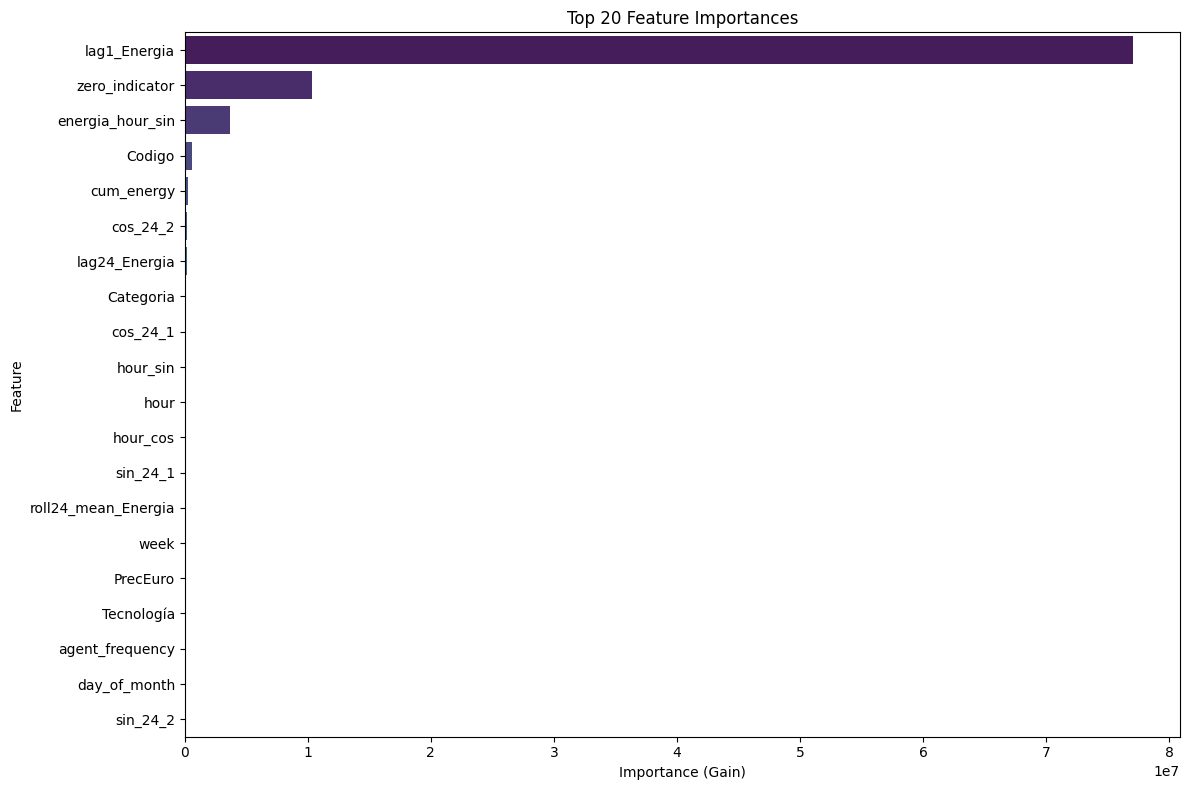

In [42]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Exporting and Plotting Feature Importances

# Extract feature importances from the final LightGBM model.
# We use "gain" as the importance type (i.e., the total gain from splits using each feature).

feature_importances = final_model.feature_importance(importance_type='gain')
feature_names = final_model.feature_name()

# Create a DataFrame of feature importances
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Export the feature importances to a CSV file

feat_imp_df.to_csv("feature_importances.csv", index=False)
print("Feature importances saved to feature_importances.csv")

# Plot the top 20 most important features

plt.figure(figsize=(12, 8))
sns.barplot(data=feat_imp_df.head(20), x='importance', y='feature', palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 2. Plotting Pairwise Relationships with Target
# --------------------------------------------------

# For further insight, we can inspect how the most important features relate to the target variable "Energia".
# Here we take the top 5 features for clarity (you can adjust this number).
top_features = feat_imp_df.head(5)['feature'].tolist()

# Create a list of columns to plot (top features + the target column)
plot_columns = top_features + ['Energia']

